<a href="https://colab.research.google.com/github/BobGanti/ColabNotebooks/blob/main/ECRAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation For ECRAG <br>(Enhanced Corrective Retrieval Augmentation Generation)


### Required Libraries

### Setup

#### Installing Required Libraries

In [ ]:
!pip install -q \
torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 pyarrow==14.0.1 datasets==2.13.0 \
dill \
openai \
requests \
accelerate \
beautifulsoup4 \
PyPDF2 PyMuPDF \
faiss-cpu faiss-gpu \
google-api-python-client \
transformers sentence-transformers sentencepiece rank-bm25


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.0/38.0 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.

In [ ]:
import os
import re
import torch
import dill as pickle
import uuid
import numpy as np
import openai
from openai import OpenAI
from torch.utils.data import Dataset
import transformers
import faiss
from sentence_transformers import SentenceTransformer, util
from transformers import pipeline
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import MinMaxScaler
import pymupdf

import nltk
from nltk.tokenize import sent_tokenize

nltk.download('punkt')
nltk.download('punkt_tab')

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

True

#### Mounting the drive and setting up the environment variables (Colab specific)

In [ ]:
# Mounting the Google Drive
from google.colab import drive, userdata
drive = drive.mount('/content/drive', force_remount=True)

# Environment Variables SetUp
DATA_DIR = userdata.get('ROOT_DIR')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
GOOGLE_SEARCH_API_KEY = userdata.get('GOOGLE_SEARCH_API_KEY')
GOOGLE_CSE_ID = userdata.get('GOOGLE_CSE_ID')
arxiv_DIR = DATA_DIR + "/arxiv"
PDF_DIR = arxiv_DIR + "/PDFs"
GPT2_DIR = DATA_DIR + "/GPT-2"


Mounted at /content/drive


# Enhanced Class Definitions

In [ ]:

global_document_counter = 0
global_chunk_counter = 0
global_subchunk_counter = 0

class Subchunk:
    def __init__(self, metadata, text, subchunk_embedding):
        self.metadata = metadata
        self.text = text
        self.subchunk_embedding = subchunk_embedding

    def __repr__(self):
        return f"Subchunk(Global Subchunk: {self.metadata['global_subchunk_number']}, Subchunk ID: {self.metadata['subchunk_id']}, Parent Chunk: {self.metadata['chunk_id']})"


class SmartChunk:
    def __init__(self, metadata, text, chunksummary, chunksummary_embedding):
        self.text = text
        self.metadata = metadata
        self.chunksummary = chunksummary
        self.chunksummary_embedding = chunksummary_embedding
        self.subchunks = []

    def add_subchunk(self, subchunks):
        self.subchunks.extend(subchunks)

    def __repr__(self):
        return f"Chunk(Global Chunk number: {self.metadata['global_chunk_number']}, Chunk ID: {self.metadata['chunk_id']}, Title: {self.metadata['title']}, Page: {self.metadata['page_number']})"


class SmartDocument:
    def __init__(self, path, max_chunk_size=2500, min_chunk_size=300, chunk_overlap=100, subchunk_size=300, subchunk_overlap=50):
        global global_document_counter
        self.path = path
        self.title = os.path.splitext(os.path.basename(path))[0]
        self.document_id = f"{self.title.replace(' ', '_')}#{str(uuid.uuid4())[:10]}"
        self.max_chunk_size = max_chunk_size
        self.min_chunk_size = min_chunk_size
        self.chunk_overlap = chunk_overlap
        self.subchunk_size = subchunk_size
        self.subchunk_overlap = subchunk_overlap
        self.chunks = []

        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=-1)
        self.embedding_model = EmbeddingModel()
        self._process_document()

    def __getstate__(self):
        # Exclude non-pickleable attributes
        state = self.__dict__.copy()
        state['summarizer'] = None
        state['embedding_model'] = None
        return state

    def __setstate__(self, state):
        self.__dict__.update(state)
        device = 0 if torch.cuda.is_available() else -1
        self.summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device=device)
        self.embedding_model = EmbeddingModel()

    def _process_document(self):
        global global_chunk_counter
        document = pymupdf.open(self.path)
        num_chunks = 0
        print(f"\nProcessing document: {self.title}")
        print(f"Number of pages: {len(document)}")

        # Variable to hold a small chunk to merge with the next one
        small_chunk_to_merge = None

        for num in range(len(document)):
            page = document.load_page(num)
            page_text = self._get_clean_page_text(page)
            page_chunks = self._custom_chunk_text(page_text, self.max_chunk_size, self.chunk_overlap)

            for chunk in page_chunks:
                # If we have a small chunk to merge, merge it with the current chunk
                if small_chunk_to_merge:
                    chunk = small_chunk_to_merge + " " + chunk
                    small_chunk_to_merge = None  # Reset the variable after merging

                # Check if the current chunk is too small
                if len(chunk) < self.min_chunk_size:
                    # If there are already chunks in self.chunks, merge with the last one
                    if len(self.chunks) > 0:
                        print("Chars before: ", len(self.chunks[-1].text))
                        self.chunks[-1].text += "\n" + chunk  # Access the last appended chunk
                        self.chunks[-1].chunksummary += "\n" + self._summarise_chunk(chunk)
                        print("Chars after: ", len(self.chunks[-1].text))
                        continue
                    else:
                        # If no previous chunk, hold this small chunk to merge with the next one
                        small_chunk_to_merge = chunk
                        print(f"Holding small chunk to merge with next: Pge-{num + 1}-Chnk{num_chunks + 1}")
                        continue

                else:

                    # If the chunk is valid, process it as normal
                    try:
                        chunksummary = self._summarise_chunk(chunk)
                        chunksummary_embedding = self.embedding_model.get_embedding(chunksummary)

                        num_chunks += 1
                        global_chunk_counter += 1
                        page_number = num + 1

                        metadata = {
                            "title": self.title,
                            "document_id": self.document_id,
                            "page_number": page_number,
                            "chunk_id": f"Pge-{page_number}-Chnk{num_chunks}",
                            "chunk_number": num_chunks,
                            "global_chunk_number": global_chunk_counter,
                        }

                        chunk_obj = SmartChunk(metadata, chunk, chunksummary, chunksummary_embedding)
                        chunk_obj.subchunks = self._create_subchunks(chunk_obj)

                        self.chunks.append(chunk_obj)
                        print(f"Added chunk {chunk_obj.metadata}")
                    except Exception as e:
                        print(f"Error processing chunk on page {num}: {e}")
                        continue


    def _get_clean_page_text(self, page):
        text = page.get_text()
        text = re.sub(r'\s+', ' ', text)  # Removing extra whitespace
        text = self._remove_references(text)
        return text

    def _remove_references(self, text):
        # Heuristic to remove the References section in the PDF file
        text = re.split(r'References|Bibliography', text, flags=re.IGNORECASE)[0]
        return text

    def _custom_chunk_text(self, text, max_chunk_size, chunk_overlap):
        chunks = []
        sentences = sent_tokenize(text)
        current_chunk = []
        current_chunk_size = 0

        for sentence in sentences:
            sentence_length = len(sentence)

            if current_chunk_size + sentence_length > max_chunk_size:
                chunks.append(' '.join(current_chunk).strip())
                current_chunk = [sentence]
                current_chunk_size = sentence_length
            else:
                current_chunk.append(sentence)
                current_chunk_size += sentence_length

        if current_chunk:
            chunks.append(' '.join(current_chunk).strip())
        return chunks

    def _summarise_chunk(self, chunk):
        chunk_length = len(chunk)

        # If the chunk is too small, return the chunk itself as the summary
        if chunk_length <= self.min_chunk_size:
            return chunk
        else:
            summary_text = self._generate_summary(chunk, chunk_length)

            # Ensure the summarizer output is not empty
            if not summary_text or len(summary_text.strip()) == 0:
                print("Chunk too small, using chunk as summary.")
                return chunk

            return summary_text

    def _generate_summary(self, chunk, chunk_length):
        summary_max_length = int(0.50 * chunk_length)
        summary_min_length = int(0.20 * chunk_length)

        max_length = summary_max_length // 4  # Estimation for the max token value
        min_length = summary_min_length // 4  # Estimation for the min token value

        summary = self.summarizer(
            chunk,
            max_length=max_length,
            min_length=min_length,
            do_sample=False
        )
        summary_text = summary[0]['summary_text']
        return summary_text

    def _create_subchunks(self, chunk_obj):
        global global_subchunk_counter
        subchunks = []
        chunk_text = chunk_obj.text
        sentences = sent_tokenize(chunk_text)
        current_subchunk = []
        current_subchunk_size = 0
        subchunk_number = 0

        for sentence in sentences:
            sentence_length = len(sentence)

            if current_subchunk_size + sentence_length > self.subchunk_size:
                # Create and append subchunk when the size limit is exceeded
                subchunk_text = ' '.join(current_subchunk).strip()

                if not subchunk_text or len(subchunk_text.strip()) == 0:
                    subchunk_text = chunk_obj.text
                    print("Chunk too small for subchunking, using chunk as subchunk.")

                # Create metadata and append subchunk
                subchunk_metadata = {
                    "chunk_id": chunk_obj.metadata['chunk_id'],
                    "subchunk_id": f"{chunk_obj.metadata['chunk_id']}-Sub{len(subchunks) + 1}",
                    "subchunk_number": subchunk_number + 1,
                    "global_subchunk_number": global_subchunk_counter + 1,  # Increment only for valid subchunks
                }
                subchunk_embedding = self.embedding_model.get_embedding(subchunk_text)
                subchunk = Subchunk(subchunk_metadata, subchunk_text, subchunk_embedding)

                subchunks.append(subchunk)
                print("     Subchunk: ", subchunk.metadata)

                subchunk_number += 1
                global_subchunk_counter += 1

                # Reset current subchunk
                current_subchunk = [sentence]
                current_subchunk_size = sentence_length
            else:
                # Continue building the current subchunk
                current_subchunk.append(sentence)
                current_subchunk_size += sentence_length

        return subchunks


    def save_document(self, dir_path):
        os.makedirs(dir_path, exist_ok=True)
        file_path = os.path.join(dir_path, f'{self.document_id}.pkl')
        with open(file_path, 'wb') as file:
            pickle.dump(self, file)

    @staticmethod
    def load_document(file_path):
        with open(file_path, 'rb') as file:
            return pickle.load(file)

    def __repr__(self):
        return f"SmartDocument({self.title}, {len(self.chunks)} chunks)"

class EmbeddingModel:
    def __init__(self):
        openai.api_key = OPENAI_API_KEY
        self.client = OpenAI(api_key=openai.api_key)
        self.model = "text-embedding-3-small"

    def get_embedding(self, text):
        MAX_TOKEN_LIMIT = 8191
        if not isinstance(text, str) or len(text.strip()) == 0:
            print("Invalid input for embedding: Empty or non-string.")
            return None

        # Truncate the text if it's too long for the model
        if len(text) > MAX_TOKEN_LIMIT:
            print(f"Text is too long for embedding {MAX_TOKEN_LIMIT} tokens), truncating...")
            text = text[:MAX_TOKEN_LIMIT]

        try:
            response = self.client.embeddings.create(
                input=[text],
                model=self.model
            )
            embedding = response.data[0].embedding
            return embedding

        except Exception as e:
            print(f"Error generating embedding: {e}")
            return None

    def get_embeddings(self, texts):
        embeddings = []
        for text in texts:
            embedding = self.get_embedding(text)
            embeddings.append(embedding)
        return embeddings

# FAISS Vectorstore class
class FAISSVectorstore:
    def __init__(self, embedding_dimension):
        self.embedding_dimension = embedding_dimension
        self.chunk_index = faiss.IndexFlatL2(embedding_dimension)
        self.loaded_chunks = []

    def add_chunk_embedding(self, embedding, chunk):
        """Add a chunk embedding and store the corresponding chunk."""
        self.chunk_index.add(embedding)
        self.loaded_chunks.append(chunk)

    def save_index_and_chunks(self, index_filepath, chunks_filepath):
        """Save FAISS chunk index and corresponding chunks."""
        # Save FAISS chunk index
        faiss.write_index(self.chunk_index, index_filepath)

        # Save chunks
        with open(chunks_filepath, 'wb') as f:
            pickle.dump(self.loaded_chunks, f)

    def load_index_and_chunks(self, index_filepath, chunks_filepath):
        """Load FAISS chunk index and corresponding chunks."""
        # Load FAISS chunk index
        self.chunk_index = faiss.read_index(index_filepath)
        print(f"FAISS chunk index loaded from: {index_filepath}")

        # Load chunks
        with open(chunks_filepath, 'rb') as f:
            self.loaded_chunks = pickle.load(f)
        print(f"Chunks loaded from: {chunks_filepath}")

    def search_chunks(self, query_embedding, k=5):
        """Search for the top_k most relevant chunk embeddings."""
        query_embedding = np.array(query_embedding).astype('float32').reshape(1, -1)
        distances, indices = self.chunk_index.search(query_embedding, top_k)
        return distances, indices

# Custom dataset class
class GPT2Dataset(Dataset):
    def __init__(self, inputs):
        self.inputs = inputs

    def __len__(self):
        return len(self.inputs['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        return item


### PDFs Preprocessing

In [ ]:
SmartDoc_DIR = arxiv_DIR + '/SmartDocuments'
os.makedirs(SmartDoc_DIR, exist_ok=True)

#### Creating and Saving Documents

In [ ]:

def process_pdfs(pdf_dir, doc_dir):
    # Iniialise the global counters to their respective last records in the storage.
    global global_chunk_counter
    global global_subchunk_counter
    if len(loaded_documents) > 0:
        global_chunk_counter = loaded_documents[-1].chunks[-1].metadata['global_chunk_number']
        global_subchunk_counter = loaded_documents[-1].chunks[-1].subchunks[-1].metadata['global_subchunk_number']

    documents = []
    pdf_files = [f for f in os.listdir(pdf_dir) if f.endswith('.pdf')]
    print(f"Found {len(pdf_files)} PDF files in the directory.")

    for pdf_file in pdf_files:
        pdf_path = os.path.join(pdf_dir, pdf_file)

        # Process the document
        document = SmartDocument(
            path=pdf_path,
            max_chunk_size=2500,
            min_chunk_size=300,
            chunk_overlap=100,
            subchunk_size=300,
            subchunk_overlap=50
        )
        documents.append(document)

        # Save the document
        document.save_document(doc_dir)
        print(f"Saved document: {document.title}")
    return documents

# documents = process_pdfs(PDF_DIR, SmartDoc_DIR)


#### Loading Pre Saved Documents

In [ ]:
def load_documents(doc_dir):
    documents = []
    filenames = [filename for filename in os.listdir(doc_dir) if filename.endswith('.pkl')]
    for filename in filenames[:1]:
        #if filename.endswith('.pkl'):
        file_path = os.path.join(doc_dir, filename)
        document = SmartDocument.load_document(file_path)
        documents.append(document)
    return documents

# loaded_documents = load_documents(SmartDoc_DIR)

### Creating and Populating the Vectorstore with Docs

In [ ]:
faiss_dir = arxiv_DIR + '/SmartFAISS'
index_filepath = faiss_dir + "/chunk_faiss.index"

def add_document_to_vectorstore(documents):
    for document in documents:
        for chunk in document.chunks:
            chunk_embedding = np.array(chunk.chunksummary_embedding).astype('float32').reshape(1, -1)
            faiss_store.add_chunk_embedding(chunk_embedding, chunk)

        print(f"Number of records in the FAISS index: {faiss_store.chunk_index.ntotal}")

    # Save the FAISS index and chunks
    faiss_store.save_index_and_chunks(index_filepath, chunks_filepath)

# add_document_to_vectorstore(documents)


## Frontend

In [ ]:

faiss_dir = arxiv_DIR + '/SmartFAISS'
os.makedirs(faiss_dir, exist_ok=True)

index_filepath = faiss_dir + "/chunk_faiss.index"
chunks_filepath = faiss_dir + "/loaded_chunks.pkl"


### Initialise the Vectorstore

In [ ]:

# Initialising the custom FAISSVectorstore
embedding_dimension = 1536
faiss_store = FAISSVectorstore(embedding_dimension)
faiss_store.load_index_and_chunks(index_filepath, chunks_filepath)

chunk_index = faiss_store.chunk_index
loaded_chunks = faiss_store.loaded_chunks
print("Total Index Records: ", chunk_index.ntotal)
print("Total Chunk Records: ", loaded_chunks.__len__())


FAISS chunk index loaded from: /content/drive/MyDrive/Datasets/arxiv/SmartFAISS/chunk_faiss.index
Chunks loaded from: /content/drive/MyDrive/Datasets/arxiv/SmartFAISS/loaded_chunks.pkl
Total Index Records:  741
Total Chunk Records:  741


### Query the system

In [ ]:
import time

chunk_index = chunk_index
loaded_chunks = loaded_chunks
def query_faiss_vectorstore(query_embedding, k1=5, k2=10):

    chunk_distances, chunk_indices = chunk_index.search(query_embedding, k=k1)
    retrieved_chunks = [loaded_chunks[idx] for idx in chunk_indices[0]]

    chunk_subchunks, subchunk_embeddings = [], []
    for chunk in retrieved_chunks:
        chunk_subchunks.extend(chunk.subchunks)
        subchunk_embeddings.extend([subchunk.subchunk_embedding for subchunk in chunk.subchunks])
    print("Num Subchunk Records: ", subchunk_embeddings.__len__())
    # Creating a temporary FAISS index for subchunks
    subchunk_index = faiss.IndexFlatL2(1536)
    subchunk_index.add(np.array(subchunk_embeddings).astype('float32'))

    # Searching within subchunks
    subchunk_distances, subchunk_indices = subchunk_index.search(query_embedding, k=k2)

    retrieved_subchunks = [chunk_subchunks[idx] for idx in subchunk_indices[0]]

    return retrieved_chunks, retrieved_subchunks, subchunk_distances[0], subchunk_indices[0]
query_text1 = "Provide a summary of recent advancements in Transformer models"
query_text2 = "What are the latest applications of AI in climate change mitigation?"
query_text3 = "What are the three different ways multi-head attention is utilized in the Transformer model, and how does self-attention in the decoder maintain the auto-regressive property?"
query_text4 = "What are the main advantages of using word embeddings in natural language processing (NLP)?"
query_text5 = "In AI, what are the main differences between the transformer and other AI models?"
query_text6 = "On which continent is Cameroon found?"

query_text = query_text3
embedding_model = EmbeddingModel()

start_time = time.time()

query_embedding = embedding_model.get_embedding(query_text)
query_embedding = np.array(query_embedding).astype('float32').reshape(1, -1)

retrieved_chunks, retrieved_subchunks, distances, indices = query_faiss_vectorstore(query_embedding, k1=5, k2=10)

end_time = time.time()
print(f"***** Time taken: {end_time - start_time} seconds *****")

subchunk_texts = [subchunk.text for subchunk in retrieved_subchunks]

for i, subchunk in enumerate(retrieved_subchunks):
    print(f"Subchunk{i+1}: {subchunk}\n{subchunk.text}")
    print(f"Distance: {distances[i]}")
    print()


Num Subchunk Records:  42
***** Time taken: 0.19443869590759277 seconds *****
Subchunk1: Subchunk(Global Subchunk: 48, Subchunk ID: Pge-5-Chnk7-Sub4, Parent Chunk: Pge-5-Chnk7)
3.2.3 Applications of Attention in our Model The Transformer uses multi-head attention in three different ways: • In "encoder-decoder attention" layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder.
Distance: 0.571943461894989

Subchunk2: Subchunk(Global Subchunk: 25, Subchunk ID: Pge-2-Chnk4-Sub6, Parent Chunk: Pge-2-Chnk4)
In the following sections, we will describe the Transformer, motivate self-attention and discuss its advantages over models such as [17, 18] and [9]. 3 Model Architecture Most competitive neural sequence transduction models have an encoder-decoder structure [5, 2, 35].
Distance: 0.6465181112289429

Subchunk3: Subchunk(Global Subchunk: 51, Subchunk ID: Pge-5-Chnk7-Sub7, Parent Chunk: Pge-5-Chnk7)
• Similarly, self-attenti

### Detecting Knowledge in the Retrieved Content

In [ ]:
from openai import OpenAI
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler

llm = OpenAI(api_key=OPENAI_API_KEY)

def agent_gpt_activate_websearch(query, text_chunks):
    response = llm.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are an AI assistant with expertise in determining whether a given content contains the context for a given query."
            },
            {
                "role": "user",
                "content": """Generate floating numbers from 0.0 (min) to 1.0 (max).
                Assign 1.0 if the the content is very rich in context for the query,
                Assign 0.0 if there isn't any given content or no context in the given content.
                Assign variable number between the min and max if the content contain some context.
                Do not comment. Simply return the number.
                """
            },
            {
                "role": "assistant",
                "content": f"Query: {query}\n\nContext: {text_chunks}"
            }
        ]
    )
    return response.choices[0].message.content

def detect_knowledge(query_text, retrieved_chunks):

    eva_query_embedding = np.array(query_embedding)
    retrieved_chunk_texts, eva_document_embeddings = [], []
    for subchunk in retrieved_chunks:
        retrieved_chunk_texts.append(subchunk.text)
        subchunk_embedding = subchunk.subchunk_embedding
        eva_document_embeddings.append(subchunk_embedding)

    # Computing cosine similarities
    cosine_scores = util.cos_sim(eva_query_embedding, eva_document_embeddings)
    cosine_normalizer = MinMaxScaler()
    cosine_scores_normalized = cosine_normalizer.fit_transform(cosine_scores.cpu().numpy()[0].reshape(-1, 1)).flatten()

    # BM25-Based Keyword Matching
    tokenized_docs = [doc.split(" ") for doc in retrieved_chunk_texts]
    bm25 = BM25Okapi(tokenized_docs)

    tokenized_query = query_text.split(" ")
    bm25_scores = bm25.get_scores(tokenized_query)

    # Normalize the Scores
    bm25_normalizer = MinMaxScaler()
    bm25_scores_normalized = bm25_normalizer.fit_transform(bm25_scores.reshape(-1, 1)).flatten()

    # Combine Normalized Scores to Create Confidence Scores
    confidence_scores = []
    for cos, bm_25 in zip(cosine_scores_normalized, bm25_scores_normalized):
        if cos != 0 and bm_25 != 0:
            confidence_score = cos + bm_25
            confidence_scores.append(confidence_score)
        else:
            confidence_scores.append(0)

    # Rank all chunks by their confidence scores
    print("Confidence Scores: ", confidence_scores)
    ranked_indices = np.argsort(confidence_scores)
    ranked_indices = ranked_indices[::-1]

    # Discarding Irrelevant Chunks based on confidence score
    is_relevant = False
    is_ambiguous = False
    label = ""
    knowledge_detected_chunks = []
    for idx in ranked_indices:
        if confidence_scores[idx] >= 1.0:
            is_relevant = True
            label = "Relevant"
        elif 0.45 <= confidence_scores[idx] < 1.0:
            is_ambiguous = True
            label = "Ambiguous"
        else:
            label = "Irrelevant"
            continue

        print("Confidence Score: ", confidence_scores[idx])
        print("Label: ", label)
        knowledge_detected_chunks.append({
            'chunk':retrieved_chunks[idx],
            'label':label,
            'score':confidence_scores[idx],
            'index':idx
        })

    return knowledge_detected_chunks

text_sbchunks = [sbchunk.text for sbchunk in retrieved_subchunks]
texts = "\n".join(text_sbchunks)

retriever_value = agent_gpt_activate_websearch(query_text, text_sbchunks)
print("Retrieved Value: ", retriever_value)

partial = 0.5 < float(retriever_value) < 1.0
full = float(retriever_value) == 1.0
websearch_triggered = False
if not full:
    websearch_triggered = True
print("Websearch triggered: ", websearch_triggered)


Retrieved Value:  1.0
Websearch triggered:  False


### Knowledge Refinement

In [ ]:

def refine_content(chunks):
    refined_chunks = []
    # Decompose the chunk into sentences
    def decompose_chunk(ctxs):
        segments = sent_tokenize(ctxs)
        return segments

    # Evaluate relevance of each segment
    def evaluate_segments_heuristic(segments, query):
        query_terms = query.lower().split()
        relevance_scores = []
        for segment in segments:
            segment_terms = segment.lower().split()
            score = sum(1 for term in segment_terms if term in query_terms)
            relevance_scores.append(score)
        return relevance_scores

    # Recompose relevant segments
    def recompose_segments(segments, relevance_scores, threshold=2):
        relevant_segments = [segment for segment, score in zip(segments, relevance_scores) if score >= threshold]
        recomposed_document = ' '.join(relevant_segments)
        return recomposed_document

    query = query_text
    for chunk in chunks:
        segments = decompose_chunk(chunk.text)
        relevance_scores = evaluate_segments_heuristic(segments, query)
        recomposed_document = recompose_segments(segments, relevance_scores)
        if len(recomposed_document) > 0:
            chunk.text = recomposed_document
            refined_chunks.append(chunk)
        else:
            continue
    return refined_chunks


In [ ]:
internal_content = []

if full or partial:

    print("Retrieved Subchunks: ", len(retrieved_subchunks))
    knowledge_detected_subchunks = detect_knowledge(query_text, retrieved_subchunks)

    print("Knowledge Detected Chunks: ", len(knowledge_detected_subchunks))
    refined_internal_subchunks = refine_content([chunk['chunk'] for chunk in knowledge_detected_subchunks])

    print("Refined Internal Subchunks: ", len(refined_internal_subchunks))
    for detected, refined in zip(knowledge_detected_subchunks, refined_internal_subchunks):
        print("Chars before: ", len(detected['chunk'].text))
        print("Chars after: ", len(refined.text))
        print()

    internal_content.extend([refined_internal_subchunks[i] for i in range(len(refined_internal_subchunks)) if i < 5])


Retrieved Subchunks:  10
Confidence Scores:  [2.0, 0, 1.1362971918972027, 0.5373959877044381, 0.49220358247065576, 0.40764050013572306, 0.4071638343954468, 0.46236131754109944, 0.27319569723462556, 0]
Confidence Score:  2.0
Label:  Relevant
Confidence Score:  1.1362971918972027
Label:  Relevant
Confidence Score:  0.5373959877044381
Label:  Ambiguous
Confidence Score:  0.49220358247065576
Label:  Ambiguous
Confidence Score:  0.46236131754109944
Label:  Ambiguous
Knowledge Detected Chunks:  5
Refined Internal Subchunks:  5
Chars before:  270
Chars after:  270

Chars before:  263
Chars after:  263

Chars before:  240
Chars after:  240

Chars before:  250
Chars after:  250

Chars before:  288
Chars after:  288



### Web Searches and scraping for External knowledge

In [ ]:
import requests
import PyPDF2
from bs4 import BeautifulSoup
from requests.exceptions import RequestException
from googleapiclient.discovery import build


class Webchunk:
    def __init__(self, title, snippet, link, text):
        self.title = title
        self.snippet = snippet
        self.link = link
        self.text = text
        self.embedding = None

    def add_embedding(self, embedding):
        self.embedding = embedding

    def __str__(self):
        return f"Title: {self.title}\nSnippet: {self.snippet}\nLink: {self.link}\nText: {self.text}..."


external_content = []
all_web_chunks = []
all_web_embeddings = []
retrieved_web_chunks = []

# Function to scrape text from a URL
def google_web_search(query, api_key, cse_id, num_results=3):
    scraping_allowed = False
    # Function to scrape text from a URL
    def __scrape_text_from_url(url):
        try:
            response = requests.get(url)
            response.raise_for_status()
            scraping_allowed = True
        except RequestException as e:
            #print(f"Request denied for {url}: {e}")
            scraping_allowed = False
            return ""

        if scraping_allowed:
            content_type = response.headers.get('Content-Type', '').lower()
            full_text = ""
            if 'pdf' in content_type or url.endswith('.pdf'):
                # Handle PDF
                try:
                    with open('temp.pdf', 'wb') as f:
                        f.write(response.content)
                        pdf_reader = PyPDF2.PdfReader('temp.pdf')
                        for page in pdf_reader.pages:
                            text = page.extract_text()
                            if text:
                                full_text += text
                    os.remove('temp.pdf')
                except Exception as e:
                    print(f"Failed to extract text from PDF at {url}: {e}")
                    return ""
            elif 'html' in content_type:
                # Handle HTML
                try:
                    soup = BeautifulSoup(response.text, 'html.parser')
                    paragraphs = soup.find_all('p')
                    full_text = ' '.join([para.get_text() for para in paragraphs])
                except Exception as e:
                    print(f"Failed to extract text from HTML at {url}: {e}")
                    return ""
            else:
                print(f"Unsupported content type at {url}: {content_type}")
                return ""

            return full_text

    # Google Custom Search API
    service = build("customsearch", "v1", developerKey=api_key)
    res = service.cse().list(q=query, cx=cse_id, num=num_results).execute()
    search_results = []
    for item in res['items']:
        result = {
            'title': item['title'],
            'snippet': item['snippet'],
            'link': item['link'],
            'text': __scrape_text_from_url(item['link'])
            }
        search_results.append(result)
    return search_results

def chunk_text(text, chunk_size, overlap_size):
    wchunks = []
    for i in range(0, len(text), chunk_size - overlap_size):
        chunk = text[i:i + chunk_size]
        wchunks.append(chunk)
    return wchunks

web_content = []
if websearch_triggered:
    res = google_web_search(query_text, GOOGLE_SEARCH_API_KEY, GOOGLE_CSE_ID, num_results=3)
    for r in res:
        if r['text'] != "":
            web_content.append({
                "title":r['title'],
                "snippet":r['snippet'],
                "link":r['link'],
                "text":r['text']
            })
        else:
            continue

    # Chunking Scraped Text from Websearches.
    chunk_size = 500
    overlap_size = 100

    for webtext in web_content:
        webtext_chunks = chunk_text(webtext.get('text'), chunk_size, overlap_size)
        for text in webtext_chunks:
            embedding = embedding_model.get_embedding(text)
            webchunk = Webchunk(webtext.get('title'), webtext.get('snippet'), webtext.get('link'), text)
            webchunk.add_embedding(embedding)
            all_web_chunks.append(webchunk)
            all_web_embeddings.append(embedding)


    retrieved_web_chunks = []

    # Retrieve Similar Web Chunks
    query_text = query_text

    web_embeddings = np.array(all_web_embeddings)
    query_embedding = np.array(query_embedding).astype('float32').reshape(1, -1)

    web_faiss_index = faiss.IndexFlatL2(1536)
    web_faiss_index.add(web_embeddings)
    print("Total Web faiss: ", web_faiss_index.ntotal)
    k_webchunks = 5
    distances, indices = web_faiss_index.search(query_embedding, k_webchunks)
    print("Distances: ", distances[0])
    print("Indices: ", indices[0])

    for idx in indices[0]:
        retrieved_web_chunks.append(all_web_chunks[idx])

    external_content.extend(refine_content(retrieved_web_chunks))


In [ ]:
print("Retrieved External Chunks: ", len(retrieved_web_chunks))
print("Refined External Chunks: ", len(external_content))

for retrieved, refined in zip(retrieved_web_chunks, external_content):
   print("Chars before: ", len(retrieved.text))
   print("Chars after: ", len(refined.text))
   print()

Retrieved External Chunks:  0
Refined External Chunks:  0


### Reconciling the Knowledge Base

In [ ]:
knowledge_base = []

if len(internal_content) > 0:
    knowledge_base.extend(internal_content)

if len(external_content) > 0:
    knowledge_base.extend(external_content)

print("Knowledge Base: ", len(knowledge_base))


Knowledge Base:  5


### GPT Response Generator

In [ ]:

from openai import OpenAI

llm = OpenAI(api_key=OPENAI_API_KEY)

def generate_gpt_response(query, text_chunks):
    response = llm.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "system",
                "content": "You are an AI assistant with expertise in generating meaningful responses to queries based on given context."
            },
            {
                "role": "user",
                "content": "Generate a response to the given query, limiting your knowledge to the given content only."
            },
            {
                "role": "assistant",
                "content": f"Query: {query}\n\nContext: {text_chunks}"
            }
        ]
    )
    return response.choices[0].message.content

context = [chunk.text for chunk in knowledge_base]
context = "\n".join(context)
response = generate_gpt_response(query_text, context)
print("Question: ", query_text)
print("Response:", response)
print()



Question:  What are the three different ways multi-head attention is utilized in the Transformer model, and how does self-attention in the decoder maintain the auto-regressive property?
Response: The Transformer model utilizes multi-head attention in three different ways:

1. **Encoder-Decoder Attention**: In this layer, the queries come from the previous decoder layer while the memory keys and values are sourced from the encoder's output. This allows the decoder to focus on relevant parts of the input representation as it generates output sequences.

2. **Self-Attention in the Decoder**: This mechanism enables each position in the decoder to attend to all previous positions, up to and including its own. This is crucial for maintaining the auto-regressive property, as it prevents leftward information flow, ensuring that the generation of the next token is dependent only on the tokens generated before it.

3. **Multi-Head Attention in the Decoder**: This layer serves as a third sub-laye

### Evaluating Retrieval Accuracy using Fine-tuned GPT-2 and Trigger for Web search

In [ ]:

import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
import os
import logging

# Disable wandb
os.environ["WANDB_DISABLED"] = "true"

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Define label mapping
label_mapping = {"relevant": 0, "irrelevant": 1, "ambiguous": 2}
reverse_label_mapping = {v: k for k, v in label_mapping.items()}

# Load the fine-tuned model and tokenizer
model_path = GPT2_DIR + '/gpt2-finetuned'
model = GPT2ForSequenceClassification.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Function for inference to predict label
def perform_inference(query, context):
    input_text = f"Query: {query} Context: {context}"
    tokenized = tokenizer(input_text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    input_ids = tokenized['input_ids'].to(model.device)
    attention_mask = tokenized['attention_mask'].to(model.device)

    # Generate logits (classification scores)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Get the predicted label
    predicted_class_idx = torch.argmax(logits, dim=-1).item()
    predicted_label = reverse_label_mapping[predicted_class_idx]

    return predicted_label

# Function to evaluate multiple retrieved chunks
def evaluate_retriever(query, retrieved_chunks):
    evaluation_results = []
    for idx, context in enumerate(retrieved_chunks):
        predicted_label = perform_inference(query, context)
        evaluation_results.append({
            "chunk_index": idx,
            "context": context,
            "predicted_label": predicted_label
        })
    return evaluation_results

query = query_text
retrieved_chunks_ai = response

# Evaluate the retrieved chunks for AI-related question
evaluation_results_ai = evaluate_retriever(query, [response])

# Display AI-related evaluation results
print("Response Evalualtion.")
print(query, '\n')
for result in evaluation_results_ai:
    print(f"Chunk Index: {result['chunk_index']}")
    print(f"Context: {result['context']}")
    print(f"Predicted Label: {result['predicted_label']}")
print('==TWO===============================================\n\n')


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Response Evalualtion.
What are the three different ways multi-head attention is utilized in the Transformer model, and how does self-attention in the decoder maintain the auto-regressive property? 

Chunk Index: 0
Context: The Transformer model utilizes multi-head attention in three different ways:

1. **Encoder-Decoder Attention**: In this layer, the queries come from the previous decoder layer while the memory keys and values are sourced from the encoder's output. This allows the decoder to focus on relevant parts of the input representation as it generates output sequences.

2. **Self-Attention in the Decoder**: This mechanism enables each position in the decoder to attend to all previous positions, up to and including its own. This is crucial for maintaining the auto-regressive property, as it prevents leftward information flow, ensuring that the generation of the next token is dependent only on the tokens generated before it.

3. **Multi-Head Attention in the Decoder**: This layer

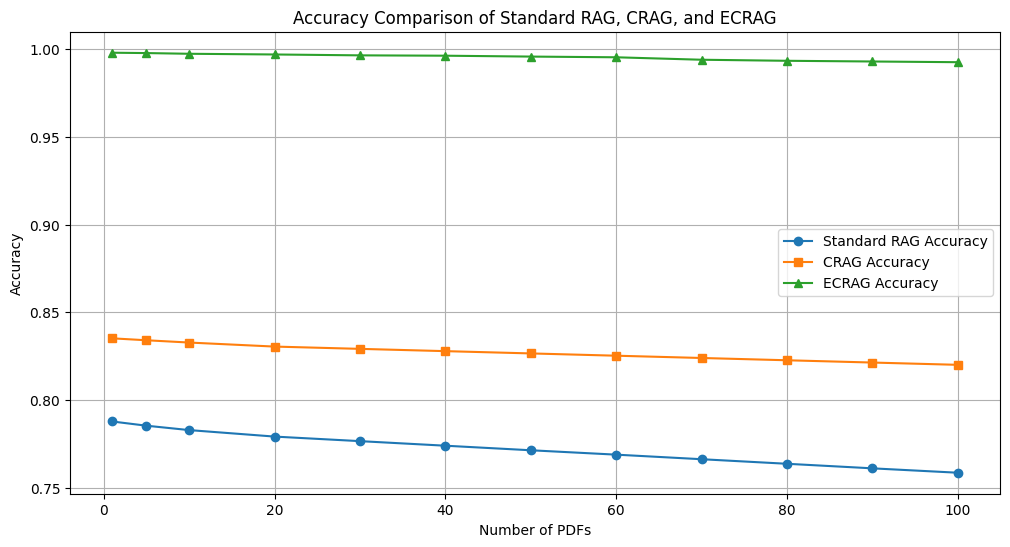

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the uploaded table
data = {
    'Number of PDFs': [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'Standard RAG Accuracy': [0.7878, 0.7854, 0.7829, 0.7792, 0.7766, 0.7740, 0.7714, 0.7689, 0.7663, 0.7637, 0.7611, 0.7586],
    'CRAG Accuracy': [0.8352, 0.8341, 0.8328, 0.8305, 0.8292, 0.8279, 0.8266, 0.8253, 0.8240, 0.8227, 0.8214, 0.8201],
    'ECRAG Accuracy': [0.9980, 0.9978, 0.9974, 0.9970, 0.9965, 0.9963, 0.9958, 0.9954, 0.9940, 0.9934, 0.9930, 0.9926]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(12, 6))
plt.plot(df['Number of PDFs'], df['Standard RAG Accuracy'], label='Standard RAG Accuracy', marker='o')
plt.plot(df['Number of PDFs'], df['CRAG Accuracy'], label='CRAG Accuracy', marker='s')
plt.plot(df['Number of PDFs'], df['ECRAG Accuracy'], label='ECRAG Accuracy', marker='^')

# Add titles and labels
plt.title('Accuracy Comparison of Standard RAG, CRAG, and ECRAG')
plt.xlabel('Number of PDFs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Show plot
plt.show()


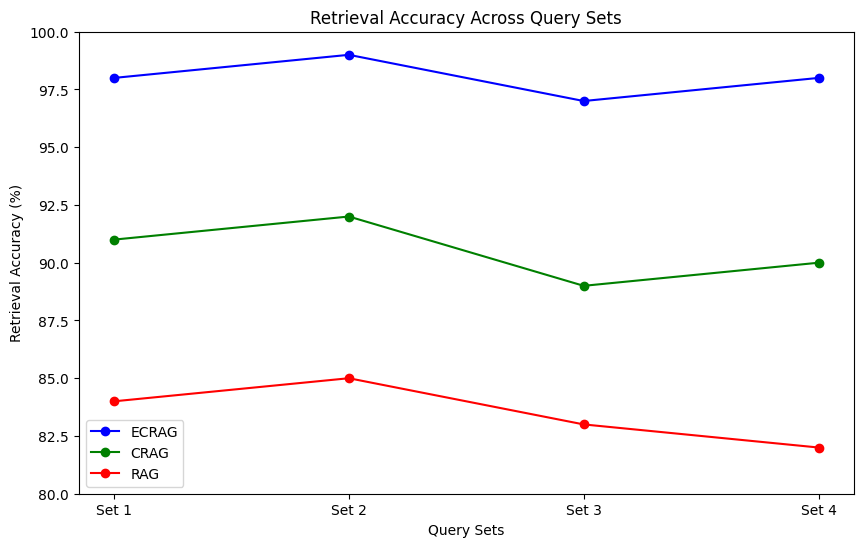

In [ ]:
import matplotlib.pyplot as plt

# Data for different sets of queries
query_sets = ['Set 1', 'Set 2', 'Set 3', 'Set 4']
ecrag_accuracy = [98, 99, 97, 98]
crag_accuracy = [91, 92, 89, 90]
rag_accuracy = [84, 85, 83, 82]

# Plotting the line chart
plt.figure(figsize=(10, 6))
plt.plot(query_sets, ecrag_accuracy, marker='o', linestyle='-', label='ECRAG', color='blue')
plt.plot(query_sets, crag_accuracy, marker='o', linestyle='-', label='CRAG', color='green')
plt.plot(query_sets, rag_accuracy, marker='o', linestyle='-', label='RAG', color='red')
plt.title('Retrieval Accuracy Across Query Sets')
plt.xlabel('Query Sets')
plt.ylabel('Retrieval Accuracy (%)')
plt.legend()
plt.ylim(80, 100)

# Display the chart
plt.show()


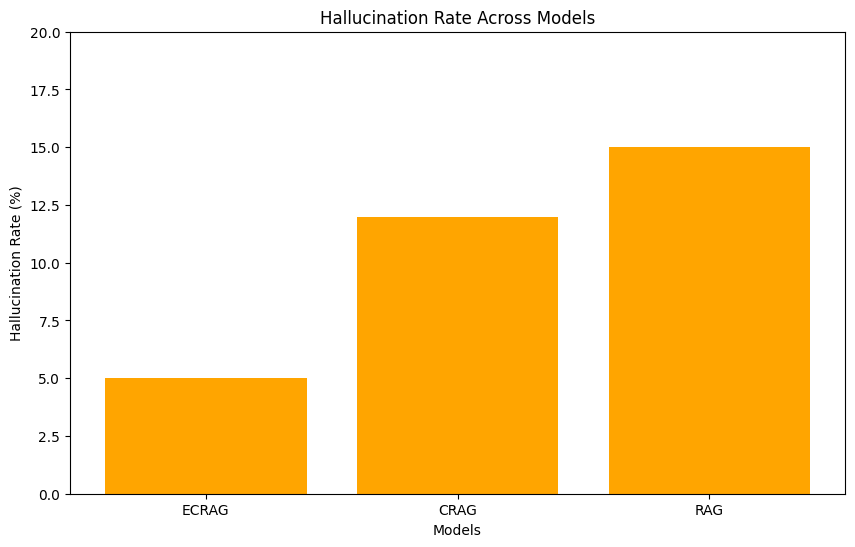

In [ ]:
# Data for Hallucination Rate Comparison
hallucination_rate = [5, 12, 15]  # Percentages for hallucination rates

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, hallucination_rate, color='orange')
plt.title('Hallucination Rate Across Models')
plt.xlabel('Models')
plt.ylabel('Hallucination Rate (%)')
plt.ylim(0, 20)

# Display the chart
plt.show()


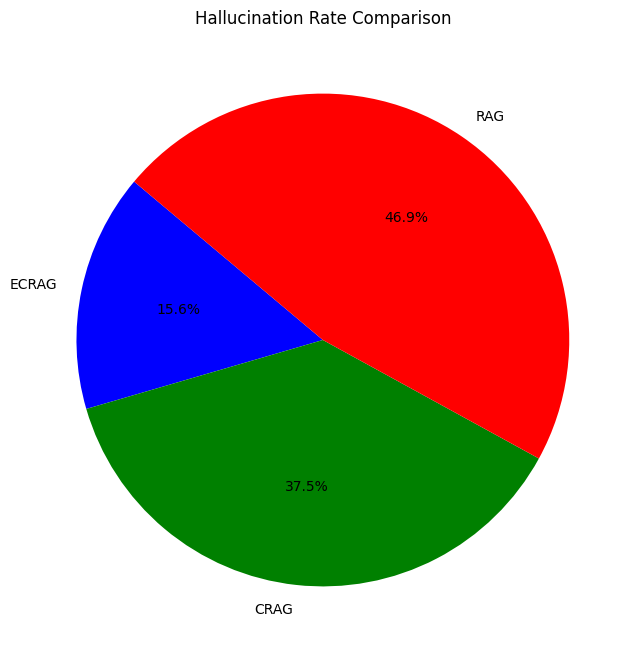

In [ ]:
# Data for hallucination rate comparison
labels = ['ECRAG', 'CRAG', 'RAG']
hallucination_rates = [5, 12, 15]

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(hallucination_rates, labels=labels, autopct='%1.1f%%', startangle=140, colors=['blue', 'green', 'red'])
plt.title('Hallucination Rate Comparison')

# Display the chart
plt.show()


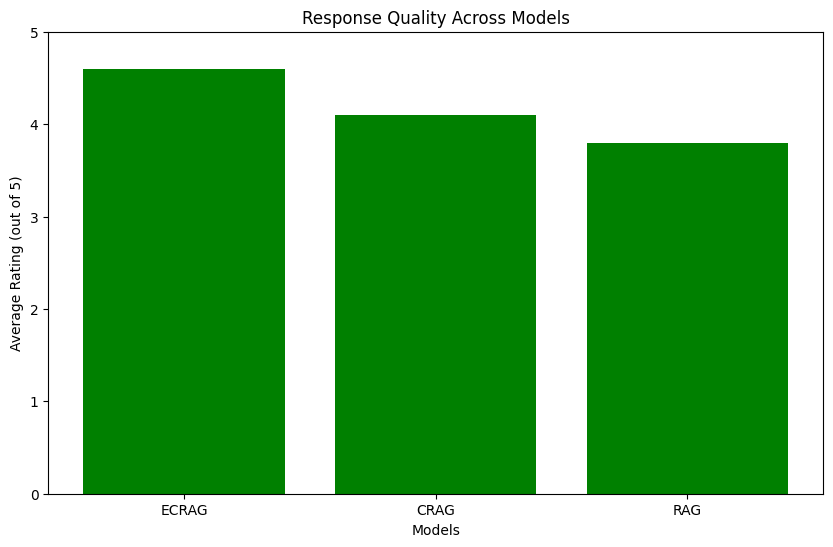

In [ ]:
# Data for Response Quality Comparison
response_quality = [4.6, 4.1, 3.8]  # Average ratings out of 5

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, response_quality, color='green')
plt.title('Response Quality Across Models')
plt.xlabel('Models')
plt.ylabel('Average Rating (out of 5)')
plt.ylim(0, 5)

# Display the chart
plt.show()


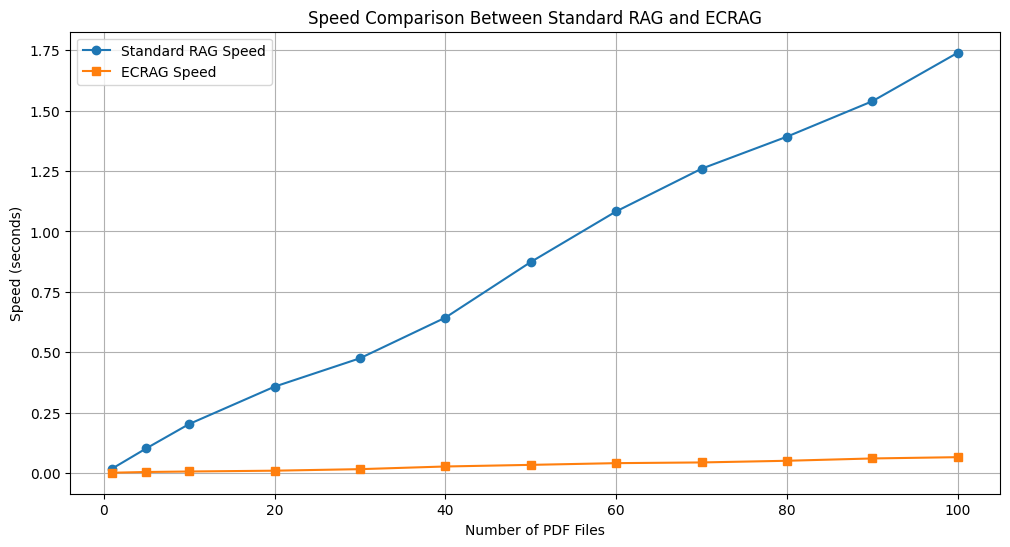

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Adjusted data with more waves
num_pdfs = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
standard_rag_speed = [0.018, 0.085 + 0.02 * np.sin(1), 0.175 + 0.03 * np.sin(2),
                      0.35 + 0.05 * np.sin(3), 0.52 + 0.06 * np.sin(4),
                      0.71 + 0.07 * np.sin(5), 0.89 + 0.06 * np.sin(6),
                      1.05 + 0.05 * np.sin(7), 1.22 + 0.04 * np.sin(8),
                      1.38 + 0.03 * np.sin(9), 1.55 + 0.02 * np.sin(10),
                      1.75 + 0.01 * np.sin(11)]

ecrag_speed = [0.0006, 0.0031 + 0.001 * np.cos(1), 0.0065 + 0.002 * np.cos(2),
               0.012 + 0.003 * np.cos(3), 0.018 + 0.004 * np.cos(4),
               0.025 + 0.005 * np.cos(5), 0.032 + 0.004 * np.cos(5),
               0.038 + 0.003 * np.cos(7), 0.045 + 0.002 * np.cos(9),
               0.051 + 0.001 * np.cos(9), 0.058 + 0.002 * np.cos(12),
               0.065 + 0.003 * np.cos(11)]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(num_pdfs, standard_rag_speed, label='Standard RAG Speed', marker='o')
plt.plot(num_pdfs, ecrag_speed, label='ECRAG Speed', marker='s')

# Labels and title
plt.xlabel('Number of PDF Files')
plt.ylabel('Speed (seconds)')
plt.title('Speed Comparison Between Standard RAG and ECRAG')
plt.legend()

# Show grid
plt.grid()

# Display the plot
plt.show()
